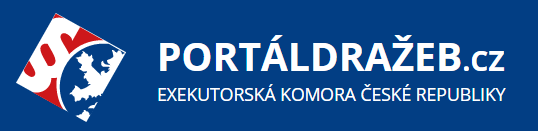

### Dynamic scraper
#### Goal
As the title suggests, the first section incorporates a data scraper. Its goal is to crawl through https://www.portaldrazeb.cz and to collect actual data about auctions and auctioneers. It also scrapes lists of auction attributes which we will subsequently use to filter the auctions with respect to location, type, etc.  
#### Problem
The problem is that the webpage has dynamic content and therefore we cannot easily extract the "static" source code as in other cases. The website also does not provide API (it actually does, however, not for us and not for the purposes we need). 
#### Solution
We use methods that handle the dynamic content - our solution is the installation of package *selenium* and setting up a *Google Chrome webdriver*. We basically open the webpage, collect its source code and navigate between pages. Thanks to this package (and the webdriver which is also included in the GitHub repository) we manage to download all the data we need. More detailed description of particular methods can be found in the class docstring and in the comments.

In [1]:
# importing the class which will do the scraping  
from dynamic_scraper import DataDownloader
down = DataDownloader() # initialising the scraper

Downloader successfully initialized!
 

    This class crawls through dynamic content of https://www.portaldrazeb.cz and collects following things:

            1) soup object for every auctioneer
            2) link to every auction + auction category (since the category is not within the auction page itself)
            3) list of all possible values from drop-down menu (auction categories, regions and districts)
    
    Subsequently it extracts soup objects of all auctions from the links collected in 2).
    


In [2]:
# link we will need
url_auctions='https://www.portaldrazeb.cz/drazby/pripravovane'

The next lines of code will scrape the data. Please do not interact with the Google Chrome window that will open in the background, just wait until it does its job and closes. The whole procedure should take a bit over 20 minutes. 

In [3]:
down.get_auction_links_and_categories(url_auctions) # takes approx. 5 minutes

100%|██████████| 57/57 [04:57<00:00,  5.22s/it]


Auction links and categories successfully downloaded! There are 1125 auctions right now.


In [4]:
down.get_items_from_dropdown_menu(url_auctions) #needs Chrome version 90 (exactly this one)

Auction categories, regions and districts successfully downloaded!


In [5]:
down.extract_auction_soups() # takes approx. 17 minutes

100%|██████████| 1125/1125 [11:44<00:00,  1.60it/s]

Soup objects successfully appended to auction_links_and_categories.


### Data processor
#### Goal
The second section contains the data processor. It accepts BeautifulSoup objects scraped in first part and extracts information about every auction. Closer information of what is collected can be found in the class description.
#### Problem
Variables in which we are interested in are scattered through the long strings. Luckily, the structure of string remains fairly consistent from auction to auction and mostly there is some substring preceding the desired information which we can find and look some constant amount of characters behind it. Also, there is a problem with Czech characters, which are encoded in a different way than we need them.
#### Solution
This problem demands an approach focused on specifics of every variable, so all necessary data were found, cleaned and put into Pandas dataframe and then a CSV file. 

In [6]:
# importing the class which will process the data
from data_processor import DataProcessor
processor = DataProcessor() # initialising the class

Processor successfully initialized!
 

    This class iterates over all soup objects returned by data scraper and collects following information about every auction:
    1) auctioneer, his/her phone and e-mail address
    2) the municipality and region (kraj) where the auction is held and GPS coordinates of the point
    3) title - what is being auctioned
    4) time when the auction begins
    5) category and subcategory to which the auctioned object belongs
    6) unique code of the auction
    7) Reserve price (vyvolávací cena) and estimated price (odhadnutá cena) of the auctioned object
    8) Link to the auction in the registry 
    


In [7]:
processor.process_data(down.auction_links_and_categories,down.regions_and_districts)

Data successfully processed!


### Data filter

In [8]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import HTML
import matplotlib.pyplot as plt

In [9]:
auctions = pd.read_csv("auctionslist.csv")
auctions=auctions.set_index("Auction_code")

In [10]:
auctions = auctions[["Title of auction","Category","Subcategory","Beginning_on","Beginning_at","Estimated_price","Reserve_price","Link","Auctioneer","Phone","E-mail","Region","District","Latitude","Longitude"]]

In [11]:
# formatting auction links to html (in order to create hyperlinks)
auctions['Link'] = auctions['Link'].apply(lambda x: f'<a href="{x}"> more info here </a>'.format(x))

In [12]:
# preparing lists of regions and districts (values for dropdown menu)
regions_and_districts = pd.DataFrame(down.regions_and_districts,columns=["Region","Districts"])
regions = ["All"]
for i in regions_and_districts["Region"]:
    regions.append(i)
districts = ["All"]
for i in regions_and_districts["Districts"].explode():
    districts.append(i)

In [13]:
# defining function which generates unique values of a column within data frame
def unique_values_and_their_counts(df, column):
    values = df[column].value_counts().index.tolist()
    counts = df[column].value_counts().tolist()
    values_plus_counts = [values[i]+": "+str(counts[i]) for i in range(len(values))] # this is used as label in pie chart
    return values, counts, values_plus_counts

In [14]:
# controlling output
output = widgets.Output() 
category_output = widgets.Output()
auctioneer_output = widgets.Output()
# setting up the widgets
region_widget = widgets.Dropdown(
    options=regions,
    value='All',
    description='Region:')
district_widget = widgets.Dropdown(
    options=districts,
    value='All',
    description='District:')

# combining effects of both widgets
def common_filtering(region, district):
    output.clear_output() # necessary to prevent from cummulating multiple outputs
    category_output.clear_output()
    auctioneer_output.clear_output()
    if (region == "All") & (district == "All"):
        common_filter = auctions
        
    elif (region == "All"):
        common_filter = auctions[auctions["District"] == district]
        
    elif (district == "All"):
        common_filter = auctions[auctions["Region"] == region]
        
    else:
        common_filter = auctions[(auctions["Region"] == region) & 
                                  (auctions["District"] == district)]
    with output:
        display(HTML(common_filter.to_html(escape=False)))
    with category_output:
        plt.pie(unique_values_and_their_counts(common_filter,"Subcategory")[1], 
                labels = unique_values_and_their_counts(common_filter,"Subcategory")[2])
        plt.show()    
    with auctioneer_output:
        fig, ax = plt.subplots()
        plt.style.use('ggplot')

        names = unique_values_and_their_counts(common_filter,"Auctioneer")[0][:8]
        number_of_auctions = unique_values_and_their_counts(common_filter,"Auctioneer")[1][:8]

        position = range(len(names))

        plt.bar(position, number_of_auctions, color='green')
        plt.xlabel("Auctioneer")
        plt.ylabel("Number of auctions")
        plt.title("Auctioneers with most auctions")

        plt.xticks(position, names)

        plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
        plt.show()
        
def dropdown_region_eventhandler(change):
    common_filtering(change.new, district_widget.value)
def dropdown_district_eventhandler(change):
    common_filtering(region_widget.value, change.new)
region_widget.observe(dropdown_region_eventhandler, names='value')
district_widget.observe(dropdown_district_eventhandler, names='value')

# creating layout for widgets and output tabs
input_widgets = widgets.HBox([region_widget,district_widget])
tab = widgets.Tab([output, category_output,auctioneer_output])
tab.set_title(0, 'Auctions')
tab.set_title(1, 'Categories')
tab.set_title(2, 'Auctioneers')

# showing the result
display(input_widgets)
display(tab)

In [165]:
#!pip install descartes
#!pip install pyshp
from descartes import PolygonPatch
import shapefile
import math
import matplotlib.pyplot as plt

In [156]:
sf=shapefile.Reader('districts')

In [157]:
regionlist=[]#this is for map of regions
countlist=[]
avglist=[]
startindices=[1,2,14,21,28,31,38,42,47,51,56,63,68,74]
endindices=[1,13,20,27,30,37,41,46,50,55,62,67,73,77]
for i in range(len(down.regions_and_districts)):
    regionlist.append(down.regions_and_districts[i][0])
for i in range(len(down.regions_and_districts)):
    count=auctions.Region[auctions.Region == regionlist[i]].count()
    countlist.append(count)
for i in range(len(down.regions_and_districts)):
    avgprice=auctions.Estimated_price[auctions.Region == regionlist[i]].mean()
    avglist.append(avgprice)

In [159]:
#this is for map of districts
districtslist=[]
districtslist.append(down.regions_and_districts[0][1][0])
down.regions_and_districts[11][1][0]
for i in range(len(down.regions_and_districts[11][1])):
    districtslist.append(down.regions_and_districts[11][1][i])
for i in range(len(down.regions_and_districts[1][1])):
    districtslist.append(down.regions_and_districts[1][1][i])
for i in range(len(down.regions_and_districts[10][1])):
    districtslist.append(down.regions_and_districts[10][1][i])
for i in range(len(down.regions_and_districts[3][1])):
    districtslist.append(down.regions_and_districts[3][1][i])
for i in range(len(down.regions_and_districts[12][1])):
    districtslist.append(down.regions_and_districts[12][1][i])
districtslist[30]=down.regions_and_districts[12][1][1]#Codes for Děčín and Chomutov are switched, as opposed to the list
districtslist[31]=down.regions_and_districts[12][1][0]
for i in range(len(down.regions_and_districts[6][1])):
    districtslist.append(down.regions_and_districts[6][1][i])
for i in range(len(down.regions_and_districts[5][1])):
    districtslist.append(down.regions_and_districts[5][1][i])
for i in range(len(down.regions_and_districts[9][1])):
    districtslist.append(down.regions_and_districts[9][1][i])
for i in range(len(down.regions_and_districts[4][1])):
    districtslist.append(down.regions_and_districts[4][1][i])
districtslist[50]=down.regions_and_districts[4][1][2]
districtslist[51]=down.regions_and_districts[4][1][0]
districtslist[52]=down.regions_and_districts[4][1][1]
for i in range(len(down.regions_and_districts[2][1])):
    districtslist.append(down.regions_and_districts[2][1][i])
districtslist[56]=down.regions_and_districts[2][1][2]
districtslist[57]=down.regions_and_districts[2][1][3]
districtslist[58]=down.regions_and_districts[2][1][1]
for i in range(len(down.regions_and_districts[8][1])):
    districtslist.append(down.regions_and_districts[8][1][i])
districtslist[62]=down.regions_and_districts[8][1][3]
districtslist[65]=down.regions_and_districts[8][1][4]
districtslist[66]=down.regions_and_districts[8][1][0]
for i in range(len(down.regions_and_districts[7][1])):
    districtslist.append(down.regions_and_districts[7][1][i])
for i in range(len(down.regions_and_districts[13][1])):
    districtslist.append(down.regions_and_districts[13][1][i])
districtslist[73]=down.regions_and_districts[13][1][3]
districtslist[74]=down.regions_and_districts[13][1][0]
districtslist[75]=down.regions_and_districts[13][1][1]
districtslist[76]=down.regions_and_districts[13][1][2]

In [166]:
d_countlist=[]
d_avglist=[]
for i in range(0,77):
    d_count=math.log(auctions.District[auctions.District == districtslist[i]].count())#log, because Prague would make everything else almost black
    d_countlist.append(d_count)
for i in range(0,77):
    d_avgprice=auctions.Estimated_price[auctions.District == districtslist[i]].mean()
    d_avglist.append(d_avgprice)

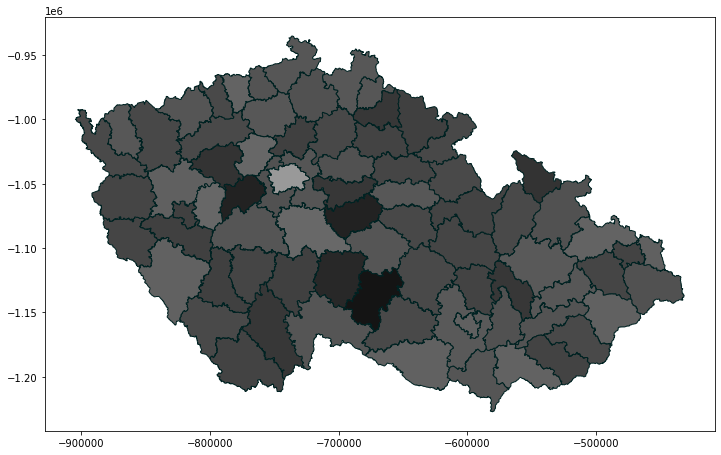

In [168]:
fig = plt.figure(figsize=(12,12)) 
ax = fig.gca()
for i in range(len(districtslist)):
    shade=int(d_countlist[i]/max(d_countlist)//0.01)#making integers to put in colour codes
    if shade>9:fillcolour="#{}{}{}".format(shade,shade,shade)
    else:fillcolour="#0{}0{}0{}".format(shade,shade,shade)#one-digit numbers would not work in the code
    poly=sf.shape(i).__geo_interface__
    ax.add_patch(PolygonPatch(poly, fc=fillcolour, ec='#002222', alpha=1, zorder=2 ))
ax.axis('scaled')
plt.show()

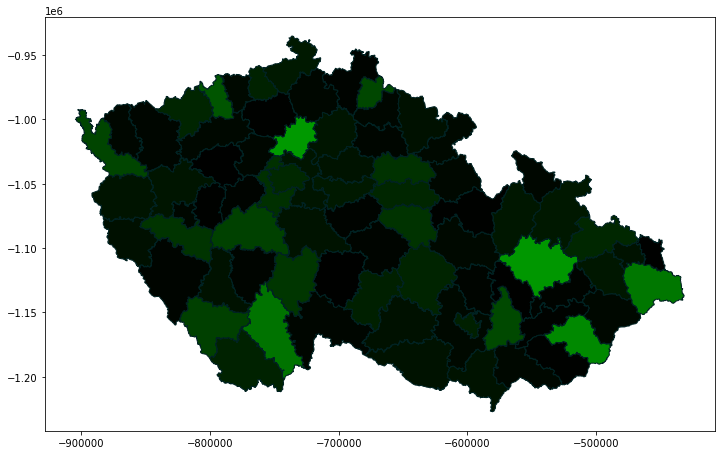

In [163]:
fig = plt.figure(figsize=(12,12)) 
ax = fig.gca()
for i in range(len(districtslist)):
    shade=int(d_avglist[i]/max(d_avglist)//0.01)#making integers to put in colour codes
    if shade>9:fillcolour="#00{}00".format(shade)
    else:fillcolour="#000{}00".format(shade)
    poly=sf.shape(i).__geo_interface__
    ax.add_patch(PolygonPatch(poly, fc=fillcolour, ec='#002222', alpha=1, zorder=2 ))
ax.axis('scaled')
plt.show()

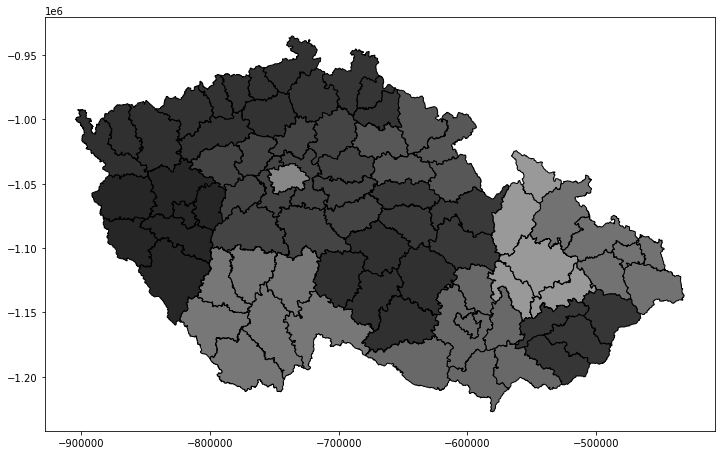

In [23]:
fig = plt.figure(figsize=(12,12)) 
ax = fig.gca()

for i in range(len(down.regions_and_districts)):
    for j in range(startindices[i]-1,endindices[i]):
        shade=int(countlist[i]/max(countlist)//0.01)#making integers to put in colour codes
        if shade>9:fillcolour="#{}{}{}".format(shade,shade,shade)
        else:fillcolour="#0{}0{}0{}".format(shade,shade,shade)#one-digit numbers would not work in the code
        poly=sf.shape(j).__geo_interface__
        ax.add_patch(PolygonPatch(poly, fc=fillcolour, ec='#000000', alpha=1, zorder=2 ))
ax.axis('scaled')
plt.show()#The lighter the colour, the more auctions there are. The region with most auctions always has shade #999999,
#other regions are coloured by their share of auctions: 10% of maximum has shade #101010, 52% has shade #525252 etc.

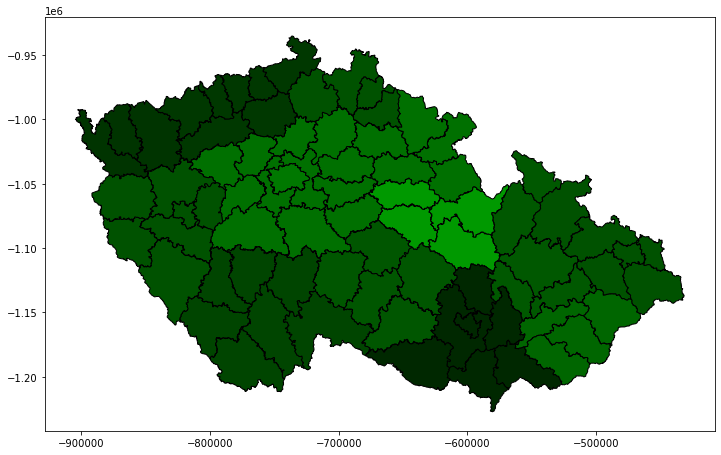

In [24]:
fig = plt.figure(figsize=(12,12)) 
ax = fig.gca()

for i in range(len(down.regions_and_districts)):
    for j in range(startindices[i]-1,endindices[i]):
        shade=int(avglist[i]/max(avglist)//0.01)
        if shade>9:fillcolour="#00{}00".format(shade)
        else:fillcolour="#000{}00".format(shade)
        poly=sf.shape(j).__geo_interface__
        ax.add_patch(PolygonPatch(poly, fc=fillcolour, ec='#000000', alpha=1, zorder=2 ))
ax.axis('scaled')
plt.show()#The lighter the colour, the more expensive auctions on average there are. Coloured by share of maximum like before. 